Changing the loss

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from AttentionModule import Conv2d_Attn

import torch
from torch import nn
from torchvision import models, datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import re
import numpy as np

In [3]:
resnet_pretrained = models.resnet101(pretrained=True)
nn.Conv2d = Conv2d_Attn
resnet_attn = models.resnet101()
resnet_attn.load_state_dict(resnet_pretrained.state_dict(), strict=False)

In [4]:
# This block turns 'layer1.0.downsample.0.weight' to 'layer1[0].downsample[0].weight'
param_keys = list(resnet_attn.state_dict().keys())
formatted_keys = []
for k in param_keys:
    found = re.findall(r'\.[\d]{1,2}\.', k)
    if len(found):
        for f in found:
            k = k.replace(f, '[{}].'.format(f.strip('.')))
    formatted_keys.append(k)

In [5]:
# This block turn off gradient up for all params except attn_weights
def turn_off_grad_except(lst=[]):
    turning_off_keys = [k for k in formatted_keys for l in lst if l in k]
    for k in formatted_keys:
        obj = eval('resnet_attn.'+k)
        if k in turning_off_keys:
            obj.requires_grad = True
        else:
            obj.requires_grad = False

In [6]:
resnet_attn.fc = nn.Linear(resnet_attn.fc.in_features, 144)

Start training

In [7]:
batch_size = 32

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose(
    [transforms.ToTensor(),
     normalize])

trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [9]:
total_imgs = len(trainset.imgs)

In [10]:
resnet_attn = resnet_attn.cuda()

In [11]:
total_attn_params = 0
for k in formatted_keys:
    obj = eval('resnet_attn.'+k)
    if 'attn_weights' in k:
        total_attn_params += np.prod(obj.shape)
print("Total number of attention parameters", total_attn_params)

Total number of attention parameters 52672


We want the attention parameters to diverge from 1, therefore we penalize element-wise square loss as $\lambda (1 \times \text{# params} - (x - 1)^2)$

But this is too big a number,
let's try: 
$- (x - 1)^2$ for now

In [12]:
_lambda = 1e-1 #set default

In [13]:
def get_params_objs(name, net='resnet_attn'):
    res = []
    for k in formatted_keys:
        obj = eval(f'{net}.'+k)
        if name in k:
            res.append(obj)
    return res

In [14]:
def compute_attn_loss(n_params=26560):
    attns = get_params_objs('attn_weights')
    penality = sum([torch.pow(t - 1,2).mean() for t in attns])
#     penality = (1000/n_params)*sum([torch.min(torch.pow(t-2, 2), torch.pow(t, 2)).sum() for t in attns])
    return (_lambda)*(-penality)

In [15]:
len(get_params_objs('attn_weights'))

104

In [16]:
compute_attn_loss()

Variable containing:
-0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [17]:
print_every = 5

In [18]:
def train_k_epoch(k, add_attn=True, score_epoch=False):
    cls_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet_attn.parameters()))
    
    for epoch in range(k):
        running_loss = 0.0
        running_attn_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()

            optimizer.zero_grad()
            outputs = resnet_attn(inputs)
            clf_loss = cls_criterion(outputs, labels)
                        
            attn_loss = compute_attn_loss()
            
            if add_attn:
                loss = clf_loss + attn_loss
            else:
                loss = clf_loss

            loss.backward()
            optimizer.step()

            running_loss += clf_loss.data[0]
            running_attn_loss += attn_loss.data[0]

            if i % print_every == 0:
                print('[%5d] iter, [%2f] epoch, classifer loss: %.3f, attn_loss: %.5f ' %
                      (i + 1, i*batch_size/total_imgs, running_loss/print_every, running_attn_loss/print_every))
                running_loss = 0.0
                running_attn_loss = 0.0
        if score_epoch:
            print(score(batch_size=32))

In [19]:
from tqdm import tqdm
def score(net=resnet_attn, batch_size=batch_size):
    trainset = torchvision.datasets.ImageFolder(root='../data/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    valset = torchvision.datasets.ImageFolder(root='../data/val', transform=transform)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    
    train_correct = 0
    val_correct = 0
    
    for inp, label in tqdm(iter(trainloader)):
        _, idx = net(Variable(inp).cuda()).max(1)
        train_correct += int(sum(idx.cpu().data == label))
    
    for inp, label in tqdm(iter(valloader)):
        _, idx = net(Variable(inp).cuda()).max(1)
        val_correct += int(sum(idx.cpu().data == label))
    
    return {
        'train_accu': train_correct/len(trainset),
        'val_accu': val_correct/len(valset)
    }

Train a fresh fc layer. 
`turn_off_grad_except([])` turns off grads for all weights but the fc layer

In [20]:
print_every = 50

In [21]:
turn_off_grad_except(['fc'])
resnet_attn.eval()
train_k_epoch(20,score_epoch=True, add_attn=False)

[    1] iter, [0.000000] epoch, classifer loss: 0.102, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 4.171, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 3.447, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 3.216, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 2.992, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 2.928, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.40693542458032106, 'val_accu': 0.33751425313568983}


[    1] iter, [0.000000] epoch, classifer loss: 0.045, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 2.371, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 2.347, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 2.348, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 2.447, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 2.343, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.29it/s]

{'train_accu': 0.47776007842176205, 'val_accu': 0.35746864310148235}


[    1] iter, [0.000000] epoch, classifer loss: 0.028, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 1.953, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 1.983, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 2.007, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 2.108, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 2.044, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.5128048033329249, 'val_accu': 0.3660205245153934}


[    1] iter, [0.000000] epoch, classifer loss: 0.047, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 1.791, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 1.778, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 1.798, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.823, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 1.778, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.565494424702855, 'val_accu': 0.37400228050171036}


[    1] iter, [0.000000] epoch, classifer loss: 0.023, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 1.542, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 1.577, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 1.649, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.622, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 1.661, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.5833843891679941, 'val_accu': 0.3603192702394527}


[    1] iter, [0.000000] epoch, classifer loss: 0.029, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 1.445, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 1.462, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 1.456, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.530, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 1.544, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.6347261365028796, 'val_accu': 0.37970353477765106}


[    1] iter, [0.000000] epoch, classifer loss: 0.025, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 1.353, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 1.328, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 1.374, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.387, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 1.373, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.632152922435976, 'val_accu': 0.36659064994298746}


[    1] iter, [0.000000] epoch, classifer loss: 0.034, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 1.175, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 1.227, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 1.269, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.292, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 1.310, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.6649920352897929, 'val_accu': 0.3814139110604333}


[    1] iter, [0.000000] epoch, classifer loss: 0.025, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 1.080, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 1.152, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 1.230, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.245, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 1.209, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.7120450925131724, 'val_accu': 0.3888255416191562}


[    1] iter, [0.000000] epoch, classifer loss: 0.024, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 1.160, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 1.092, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 1.111, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.106, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 1.165, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.719887268717069, 'val_accu': 0.37457240592930446}


[    1] iter, [0.000000] epoch, classifer loss: 0.017, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 1.007, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 1.065, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 1.015, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.102, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 1.099, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.7365518931503492, 'val_accu': 0.3768529076396807}


[    1] iter, [0.000000] epoch, classifer loss: 0.023, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 0.879, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 0.915, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 1.058, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.042, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 1.077, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.27it/s]

{'train_accu': 0.7722092880774415, 'val_accu': 0.3814139110604333}


[    1] iter, [0.000000] epoch, classifer loss: 0.020, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 0.947, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 0.918, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 0.965, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 1.020, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 0.958, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.7736796961156721, 'val_accu': 0.3905359179019384}


[    1] iter, [0.000000] epoch, classifer loss: 0.013, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 0.902, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 0.891, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 0.910, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 0.882, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 0.922, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.7796838622717804, 'val_accu': 0.4013683010262258}


[    1] iter, [0.000000] epoch, classifer loss: 0.021, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 0.909, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 0.821, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 0.874, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 0.869, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 0.892, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.7457419433892906, 'val_accu': 0.3734321550741163}


[    1] iter, [0.000000] epoch, classifer loss: 0.019, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 0.815, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 0.808, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 0.797, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 0.866, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 0.838, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.772821958093371, 'val_accu': 0.37799315849486886}


[    1] iter, [0.000000] epoch, classifer loss: 0.013, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 0.841, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 0.775, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 0.787, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 0.811, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 0.803, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.7881387084916064, 'val_accu': 0.37115165336374}


[    1] iter, [0.000000] epoch, classifer loss: 0.009, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 0.706, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 0.710, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 0.780, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 0.804, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 0.759, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.7940203406445289, 'val_accu': 0.3757126567844926}


[    1] iter, [0.000000] epoch, classifer loss: 0.013, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 0.709, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 0.703, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 0.733, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 0.733, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 0.743, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.8247763754441858, 'val_accu': 0.3979475484606613}


[    1] iter, [0.000000] epoch, classifer loss: 0.015, attn_loss: 0.00000 
[   51] iter, [0.196054] epoch, classifer loss: 0.686, attn_loss: 0.00000 
[  101] iter, [0.392109] epoch, classifer loss: 0.681, attn_loss: 0.00000 
[  151] iter, [0.588163] epoch, classifer loss: 0.671, attn_loss: 0.00000 
[  201] iter, [0.784218] epoch, classifer loss: 0.752, attn_loss: 0.00000 
[  251] iter, [0.980272] epoch, classifer loss: 0.740, attn_loss: 0.00000 


100%|██████████| 55/55 [00:24<00:00,  2.28it/s]

{'train_accu': 0.8177919372625904, 'val_accu': 0.3717217787913341}


```
{'train_accu': 0.40693542458032106, 'val_accu': 0.33751425313568983}
{'train_accu': 0.47776007842176205, 'val_accu': 0.35746864310148235}
{'train_accu': 0.5128048033329249, 'val_accu': 0.3660205245153934}
{'train_accu': 0.565494424702855, 'val_accu': 0.37400228050171036}
{'train_accu': 0.5833843891679941, 'val_accu': 0.3603192702394527}
{'train_accu': 0.6347261365028796, 'val_accu': 0.37970353477765106}
{'train_accu': 0.632152922435976, 'val_accu': 0.36659064994298746}
{'train_accu': 0.6649920352897929, 'val_accu': 0.3814139110604333}
{'train_accu': 0.7120450925131724, 'val_accu': 0.3888255416191562}
{'train_accu': 0.719887268717069, 'val_accu': 0.37457240592930446}
{'train_accu': 0.7365518931503492, 'val_accu': 0.3768529076396807}
{'train_accu': 0.7722092880774415, 'val_accu': 0.3814139110604333}
{'train_accu': 0.7736796961156721, 'val_accu': 0.3905359179019384}
{'train_accu': 0.7796838622717804, 'val_accu': 0.4013683010262258}
{'train_accu': 0.7457419433892906, 'val_accu': 0.3734321550741163}
{'train_accu': 0.772821958093371, 'val_accu': 0.37799315849486886}
{'train_accu': 0.7881387084916064, 'val_accu': 0.37115165336374}
{'train_accu': 0.7940203406445289, 'val_accu': 0.3757126567844926}
{'train_accu': 0.8247763754441858, 'val_accu': 0.3979475484606613}
{'train_accu': 0.8177919372625904, 'val_accu': 0.3717217787913341}
```

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [23]:
raw = """
{'train_accu': 0.40693542458032106, 'val_accu': 0.33751425313568983}
{'train_accu': 0.47776007842176205, 'val_accu': 0.35746864310148235}
{'train_accu': 0.5128048033329249, 'val_accu': 0.3660205245153934}
{'train_accu': 0.565494424702855, 'val_accu': 0.37400228050171036}
{'train_accu': 0.5833843891679941, 'val_accu': 0.3603192702394527}
{'train_accu': 0.6347261365028796, 'val_accu': 0.37970353477765106}
{'train_accu': 0.632152922435976, 'val_accu': 0.36659064994298746}
{'train_accu': 0.6649920352897929, 'val_accu': 0.3814139110604333}
{'train_accu': 0.7120450925131724, 'val_accu': 0.3888255416191562}
{'train_accu': 0.719887268717069, 'val_accu': 0.37457240592930446}
{'train_accu': 0.7365518931503492, 'val_accu': 0.3768529076396807}
{'train_accu': 0.7722092880774415, 'val_accu': 0.3814139110604333}
{'train_accu': 0.7736796961156721, 'val_accu': 0.3905359179019384}
{'train_accu': 0.7796838622717804, 'val_accu': 0.4013683010262258}
{'train_accu': 0.7457419433892906, 'val_accu': 0.3734321550741163}
{'train_accu': 0.772821958093371, 'val_accu': 0.37799315849486886}
{'train_accu': 0.7881387084916064, 'val_accu': 0.37115165336374}
{'train_accu': 0.7940203406445289, 'val_accu': 0.3757126567844926}
{'train_accu': 0.8247763754441858, 'val_accu': 0.3979475484606613}
{'train_accu': 0.8177919372625904, 'val_accu': 0.3717217787913341}
"""

In [24]:
from ast import literal_eval

In [29]:
df = pd.DataFrame.from_dict([
    literal_eval(d.rstrip('\n'))
    for d in raw.splitlines()[1:-1]
])

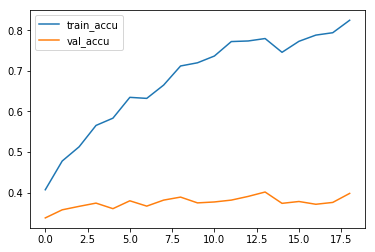

In [31]:
df.plot()